# Fisheries competition

In this notebook we're going to investigate a range of different architectures for the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/).  The video states that vgg.py and ``vgg_ft()`` from utils.py have been updated to include VGG with batch normalization, but this is not the case.  We've instead created a new file [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py) and an additional method ``vgg_ft_bn()`` (which is already in utils.py) which we use in this notebook.

In [281]:
%matplotlib inline
import utils; import importlib; importlib.reload(utils)
from utils import *
from __future__ import division, print_function

In [2]:
#path = "data/fish/sample/"
path = "data/fish/"
batch_size=64

Download `train.zip` and `test_stg1.zip` from competition, and place it in `path`

In [13]:
%%bash
rm -rf data/fish/train
rm -rf data/fish/valid
rm -rf data/fish/test
rm -rf data/fish/__MACOSX
unzip data/fish/train.zip -d data/fish
mkdir data/fish/test
unzip data/fish/test_stg1.zip -d data/fish/test
mkdir data/fish/valid

Archive:  data/fish/train.zip
   creating: data/fish/train/
  inflating: data/fish/train/.DS_Store  
   creating: data/fish/__MACOSX/
   creating: data/fish/__MACOSX/train/
  inflating: data/fish/__MACOSX/train/._.DS_Store  
   creating: data/fish/train/ALB/
  inflating: data/fish/train/ALB/img_00003.jpg  
  inflating: data/fish/train/ALB/img_00010.jpg  
  inflating: data/fish/train/ALB/img_00012.jpg  
  inflating: data/fish/train/ALB/img_00015.jpg  
  inflating: data/fish/train/ALB/img_00019.jpg  
  inflating: data/fish/train/ALB/img_00020.jpg  
  inflating: data/fish/train/ALB/img_00029.jpg  
  inflating: data/fish/train/ALB/img_00032.jpg  
  inflating: data/fish/train/ALB/img_00037.jpg  
  inflating: data/fish/train/ALB/img_00038.jpg  
  inflating: data/fish/train/ALB/img_00039.jpg  
  inflating: data/fish/train/ALB/img_00041.jpg  
  inflating: data/fish/train/ALB/img_00043.jpg  
  inflating: data/fish/train/ALB/img_00045.jpg  
  inflating: data/fish/train/ALB/img_00055.jpg  
  infl

In [14]:
import os
import os.path
import random

for subdir in os.listdir(path + 'train'):
    if not os.path.isdir(path + 'train/' + subdir):
        continue
    os.mkdir(path + 'valid/' + subdir)
    images = os.listdir(path + 'train/' + subdir)
    images = [im for im in images if im.endswith('.jpg')]
    random.shuffle(images)
    for im in images[:len(images) // 10]:
        os.rename(path + 'train/' + subdir + '/' + im, path + 'valid/' + subdir + '/' + im)
        

In [15]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 3404 images belonging to 8 classes.
Found 373 images belonging to 8 classes.
Found 3404 images belonging to 8 classes.
Found 373 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


Sometimes it's helpful to have just the filenames, without the path.

In [16]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

## Setup dirs

We create the validation and sample sets in the usual way.

In [17]:
%cd data/fish
%cd train

/home/cberner/Code/fastai_courses/deeplearning1/nbs/data/fish
/home/cberner/Code/fastai_courses/deeplearning1/nbs/data/fish/train


In [18]:
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

In [19]:
from shutil import copyfile

g = glob('*')
for d in g: 
    os.mkdir('../sample/train/'+d)
    os.mkdir('../sample/valid/'+d)

In [20]:
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(400): copyfile(shuf[i], '../sample/train/' + shuf[i])

%cd ../valid

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/valid/' + shuf[i])

%cd ..

/home/cberner/Code/fastai_courses/deeplearning1/nbs/data/fish/valid
/home/cberner/Code/fastai_courses/deeplearning1/nbs/data/fish


In [21]:
%mkdir results
%mkdir sample/results
%cd ../..

/home/cberner/Code/fastai_courses/deeplearning1/nbs


## Basic VGG

We start with our usual VGG approach.  We will be using VGG with batch normalization.  We explained how to add batch normalization to VGG in the [imagenet_batchnorm notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/imagenet_batchnorm.ipynb).  VGG with batch normalization is implemented in [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py), and there is a version of ``vgg_ft`` (our fine tuning function) with batch norm called ``vgg_ft_bn`` in [utils.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py).

### Initial model

First we create a simple fine-tuned VGG model to be our starting point.

In [22]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)

In [23]:
trn = get_data(path+'train')
val = get_data(path+'valid')

Found 3404 images belonging to 8 classes.
Found 373 images belonging to 8 classes.


In [24]:
test = get_data(path+'test')

Found 1000 images belonging to 1 classes.


In [25]:
save_array(path+'results/trn.dat', trn)
save_array(path+'results/val.dat', val)

In [26]:
save_array(path+'results/test.dat', test)

In [27]:
trn = load_array(path+'results/trn.dat')
val = load_array(path+'results/val.dat')

In [28]:
test = load_array(path+'results/test.dat')

In [31]:
gen = image.ImageDataGenerator()

In [32]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.fit(trn, trn_labels, batch_size=batch_size, epochs=3, validation_data=(val, val_labels))

Train on 3404 samples, validate on 373 samples
Epoch 1/3
3404/3404 [==============================] - 15s 4ms/step - loss: 2.8163 - acc: 0.4871 - val_loss: 1.2770 - val_acc: 0.6729
Epoch 2/3
3404/3404 [==============================] - 12s 4ms/step - loss: 1.5818 - acc: 0.6533 - val_loss: 0.7021 - val_acc: 0.8150
Epoch 3/3
3404/3404 [==============================] - 12s 4ms/step - loss: 1.2717 - acc: 0.7159 - val_loss: 0.5338 - val_acc: 0.8606


In [34]:
model.save_weights(path+'results/ft1.h5')

### Precompute convolutional output

We pre-compute the output of the last convolution layer of VGG, since we're unlikely to need to fine-tune those layers. (All following analysis will be done on just the pre-computed convolutional features.)

In [35]:
model.load_weights(path+'results/ft1.h5')

In [36]:
conv_layers,fc_layers = split_at(model, Conv2D)

In [37]:
conv_model = Sequential(conv_layers)

In [38]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)

In [39]:
conv_test_feat = conv_model.predict(test)

In [40]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)

In [41]:
save_array(path+'results/conv_test_feat.dat', conv_test_feat)

In [42]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

In [43]:
conv_test_feat = load_array(path+'results/conv_test_feat.dat')

In [44]:
conv_val_feat.shape

(373, 512, 14, 14)

### Train model

We can now create our first baseline model - a simple 3-layer FC net.

In [45]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

In [46]:
p=0.6

In [47]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, epochs=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 3404 samples, validate on 373 samples
Epoch 1/3
3404/3404 [==============================] - 2s 510us/step - loss: 1.1105 - acc: 0.6724 - val_loss: 0.5627 - val_acc: 0.9062
Epoch 2/3
3404/3404 [==============================] - 1s 318us/step - loss: 0.3054 - acc: 0.9133 - val_loss: 0.1566 - val_acc: 0.9598
Epoch 3/3
3404/3404 [==============================] - 1s 305us/step - loss: 0.1533 - acc: 0.9580 - val_loss: 0.1499 - val_acc: 0.9571


In [49]:
bn_model.optimizer.lr = 1e-4

In [50]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, epochs=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 3404 samples, validate on 373 samples
Epoch 1/7
3404/3404 [==============================] - 1s 318us/step - loss: 0.1081 - acc: 0.9692 - val_loss: 0.1314 - val_acc: 0.9732
Epoch 2/7
3404/3404 [==============================] - 1s 313us/step - loss: 0.0716 - acc: 0.9797 - val_loss: 0.0934 - val_acc: 0.9866
Epoch 3/7
3404/3404 [==============================] - 1s 307us/step - loss: 0.0682 - acc: 0.9815 - val_loss: 0.1004 - val_acc: 0.9759
Epoch 4/7
3404/3404 [==============================] - 1s 305us/step - loss: 0.0485 - acc: 0.9874 - val_loss: 0.1065 - val_acc: 0.9732
Epoch 5/7
3404/3404 [==============================] - 1s 311us/step - loss: 0.0453 - acc: 0.9877 - val_loss: 0.0809 - val_acc: 0.9812
Epoch 6/7
3404/3404 [==============================] - 1s 306us/step - loss: 0.0415 - acc: 0.9891 - val_loss: 0.1025 - val_acc: 0.9812
Epoch 7/7
3404/3404 [==============================] - 1s 314us/step - loss: 0.0463 - acc: 0.9891 - val_loss: 0.1063 - val_acc: 0.9786


In [52]:
%mkdir data/fish/models

In [53]:
bn_model.save_weights(path+'models/conv_512_6.h5')

In [54]:
bn_model.evaluate(conv_val_feat, val_labels)

373/373 [==============================] - 0s 265us/step


[0.10625456911185178, 0.97855227882037532]

In [55]:
bn_model.load_weights(path+'models/conv_512_6.h5')

## Multi-input

The images are of different sizes, which are likely to represent the boat they came from (since different boats will use different cameras). Perhaps this creates some data leakage that we can take advantage of to get a better Kaggle leaderboard position? To find out, first we create arrays of the file sizes for each image:

In [56]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [57]:
import collections
collections.Counter(sizes)

Counter({(1192, 670): 181,
         (1244, 700): 24,
         (1276, 718): 192,
         (1280, 720): 1954,
         (1280, 750): 545,
         (1280, 924): 56,
         (1280, 974): 356,
         (1334, 750): 29,
         (1518, 854): 37,
         (1732, 974): 30})

Then we one-hot encode them (since we want to treat them as categorical) and normalize the data.

In [58]:
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

In [251]:
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))
raw_test_sizes = [PIL.Image.open(path+'test/'+f).size for f in test_filenames]
test_sizes = to_categorical([size2id[o] for o in raw_test_sizes], len(id2size))

In [252]:
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
test_sizes = test_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

To use this additional "meta-data", we create a model with multiple input layers - `sz_inp` will be our input for the size information.

In [61]:
p=0.6

In [63]:
from keras.layers.merge import concatenate
inp = Input(conv_layers[-1].output_shape[1:])
sz_inp = Input((len(id2size),))
bn_inp = BatchNormalization()(sz_inp)

x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = concatenate([x,bn_inp])
x = Dense(8, activation='softmax')(x)

When we compile the model, we have to specify all the input layers in an array.

In [64]:
model = Model([inp, sz_inp], x)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

And when we train the model, we have to provide all the input layers' data in an array.

In [65]:
model.fit([conv_feat, trn_sizes], trn_labels, batch_size=batch_size, epochs=3, 
             validation_data=([conv_val_feat, val_sizes], val_labels))

Train on 3404 samples, validate on 373 samples
Epoch 1/3
3404/3404 [==============================] - 2s 592us/step - loss: 1.0452 - acc: 0.6857 - val_loss: 0.6208 - val_acc: 0.9088
Epoch 2/3
3404/3404 [==============================] - 1s 324us/step - loss: 0.2793 - acc: 0.9172 - val_loss: 0.1347 - val_acc: 0.9678
Epoch 3/3
3404/3404 [==============================] - 1s 313us/step - loss: 0.1375 - acc: 0.9592 - val_loss: 0.0950 - val_acc: 0.9812


In [66]:
bn_model.optimizer.lr = 1e-4

In [67]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, epochs=8, 
             validation_data=(conv_val_feat, val_labels))

Train on 3404 samples, validate on 373 samples
Epoch 1/8
3404/3404 [==============================] - 1s 316us/step - loss: 0.0277 - acc: 0.9927 - val_loss: 0.1038 - val_acc: 0.9839
Epoch 2/8
3404/3404 [==============================] - 1s 321us/step - loss: 0.0201 - acc: 0.9938 - val_loss: 0.1587 - val_acc: 0.9759
Epoch 3/8
3404/3404 [==============================] - 1s 320us/step - loss: 0.0322 - acc: 0.9921 - val_loss: 0.1315 - val_acc: 0.9786
Epoch 4/8
3404/3404 [==============================] - 1s 309us/step - loss: 0.0306 - acc: 0.9927 - val_loss: 0.1341 - val_acc: 0.9759
Epoch 5/8
3404/3404 [==============================] - 1s 312us/step - loss: 0.0233 - acc: 0.9944 - val_loss: 0.1289 - val_acc: 0.9759
Epoch 6/8
3404/3404 [==============================] - 1s 324us/step - loss: 0.0328 - acc: 0.9906 - val_loss: 0.1121 - val_acc: 0.9786
Epoch 7/8
3404/3404 [==============================] - 1s 327us/step - loss: 0.0230 - acc: 0.9929 - val_loss: 0.1092 - val_acc: 0.9759
Epoch 8/

The model did not show an improvement by using the leakage, other than in the early epochs. This is most likely because the information about what boat the picture came from is readily identified from the image itself, so the meta-data turned out not to add any additional information.

## Bounding boxes & multi output

### Import / view bounding boxes

A kaggle user has created bounding box annotations for each fish in each training set image. You can download them [from here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/forums/t/25902/complete-bounding-box-annotation). We will see if we can utilize this additional information. First, we'll load in the data, and keep just the largest bounding box for each image.

In [69]:
import ujson as json

In [70]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [73]:
def get_annotations():
    annot_urls = {
        '5458/bet_labels.json': 'bd20591439b650f44b36b72a98d3ce27',
        '5459/shark_labels.json': '94b1b3110ca58ff4788fb659eda7da90',
        '5460/dol_labels.json': '91a25d29a29b7e8b8d7a8770355993de',
        '5461/yft_labels.json': '9ef63caad8f076457d48a21986d81ddc',
        '5462/alb_labels.json': '731c74d347748b5272042f0661dad37c',
        '5463/lag_labels.json': '92d75d9218c3333ac31d74125f2b380a'
    }
    cache_subdir = os.path.abspath(os.path.join(path, 'annos'))
    url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
    
    if not os.path.exists(cache_subdir):
        os.makedirs(cache_subdir)
    
    for url_suffix, md5_hash in annot_urls.items():
        fname = url_suffix.rsplit('/', 1)[-1]
        get_file(fname, url_prefix + url_suffix, cache_subdir=cache_subdir, md5_hash=md5_hash)

In [74]:
get_annotations()

73728/68097 [================================] - 0s 1us/step


In [75]:
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for "other" class
    j = json.load(open('{}annos/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [76]:
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [77]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

For any images that have no annotations, we'll create an empty bounding box.

In [78]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [79]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

In [80]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [81]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

Now we can check our work by drawing one of the annotations.

In [82]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

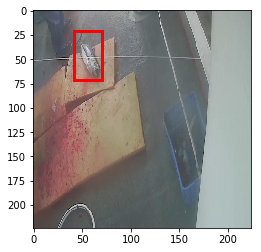

In [83]:
show_bb(0)

### Create & train model

Since we're not allowed (by the kaggle rules) to manually annotate the test set, we'll need to create a model that predicts the locations of the bounding box on each image. To do so, we create a model with multiple outputs: it will predict both the type of fish (the 'class'), and the 4 bounding box coordinates. We prefer this approach to only predicting the bounding box coordinates, since we hope that giving the model more context about what it's looking for will help it with both tasks.

In [84]:
p=0.6

In [85]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

Since we have multiple outputs, we need to provide them to the model constructor in an array, and we also need to say what loss function to use for each. We also weight the bounding box loss function down by 1000x since the scale of the cross-entropy loss and the MSE is very different.

In [86]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

In [87]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, epochs=3, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3404 samples, validate on 373 samples
Epoch 1/3
3404/3404 [==============================] - 2s 647us/step - loss: 5.5522 - bb_loss: 4518.1427 - class_loss: 1.0340 - bb_acc: 0.4280 - class_acc: 0.6865 - val_loss: 4.2810 - val_bb_loss: 3657.5626 - val_class_loss: 0.6235 - val_bb_acc: 0.5737 - val_class_acc: 0.9115
Epoch 2/3
3404/3404 [==============================] - 1s 324us/step - loss: 4.5389 - bb_loss: 4233.0278 - class_loss: 0.3059 - bb_acc: 0.5044 - class_acc: 0.9086 - val_loss: 3.6622 - val_bb_loss: 3473.6856 - val_class_loss: 0.1885 - val_bb_acc: 0.5416 - val_class_acc: 0.9491
Epoch 3/3
3404/3404 [==============================] - 1s 328us/step - loss: 3.8460 - bb_loss: 3693.3765 - class_loss: 0.1527 - bb_acc: 0.5229 - class_acc: 0.9536 - val_loss: 3.0740 - val_bb_loss: 2947.8993 - val_class_loss: 0.1261 - val_bb_acc: 0.5791 - val_class_acc: 0.9732


In [88]:
model.optimizer.lr = 1e-5

In [89]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, epochs=10, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3404 samples, validate on 373 samples
Epoch 1/10
3404/3404 [==============================] - 1s 331us/step - loss: 3.0760 - bb_loss: 2974.1643 - class_loss: 0.1018 - bb_acc: 0.5752 - class_acc: 0.9733 - val_loss: 2.5785 - val_bb_loss: 2447.9829 - val_class_loss: 0.1306 - val_bb_acc: 0.6005 - val_class_acc: 0.9678
Epoch 2/10
3404/3404 [==============================] - 1s 339us/step - loss: 2.3218 - bb_loss: 2253.8354 - class_loss: 0.0679 - bb_acc: 0.5940 - class_acc: 0.9786 - val_loss: 1.8921 - val_bb_loss: 1782.8432 - val_class_loss: 0.1093 - val_bb_acc: 0.6300 - val_class_acc: 0.9786
Epoch 3/10
3404/3404 [==============================] - 1s 349us/step - loss: 1.5982 - bb_loss: 1553.5307 - class_loss: 0.0446 - bb_acc: 0.6196 - class_acc: 0.9865 - val_loss: 1.2002 - val_bb_loss: 1088.9038 - val_class_loss: 0.1113 - val_bb_acc: 0.6729 - val_class_acc: 0.9812
Epoch 4/10
3404/3404 [==============================] - 1s 332us/step - loss: 1.0183 - bb_loss: 968.2544 - class_loss: 

Excitingly, it turned out that the classification model is much improved by giving it this additional task. Let's see how well the bounding box model did by taking a look at its output.

In [90]:
pred = model.predict(conv_val_feat[0:10])

In [91]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

The image shows that it can find fish that are tricky for us to see!

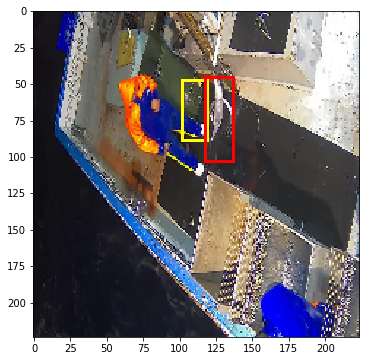

In [92]:
show_bb_pred(6)

In [93]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

373/373 [==============================] - 0s 186us/step


[0.30503216645513082,
 204.2485722191532,
 0.10078358356953267,
 0.78552278820375332,
 0.98123324396782841]

In [94]:
model.save_weights(path+'models/bn_anno.h5')

In [95]:
model.load_weights(path+'models/bn_anno.h5')

## Larger size

### Set up data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier (1280x720), without being too big.

In [96]:
trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))

Found 3404 images belonging to 8 classes.
Found 373 images belonging to 8 classes.


The image shows that things are much clearer at this size.

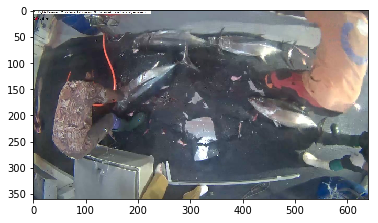

In [97]:
plot(trn[0])

In [98]:
test = get_data(path+'test', (360,640))

Found 1000 images belonging to 1 classes.


In [99]:
save_array(path+'results/trn_640.dat', trn)
save_array(path+'results/val_640.dat', val)

In [100]:
save_array(path+'results/test_640.dat', test)

In [101]:
trn = load_array(path+'results/trn_640.dat')
val = load_array(path+'results/val_640.dat')

We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images, which also means it won't include the fully connected layers (since they don't make sense for non-default sizes). We will also remove the last max pooling layer, since we don't want to throw away information yet.

In [102]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

58908672/58902640 [==============================] - 19s 0us/step


We can now pre-compute the output of the convolutional part of VGG.

In [103]:
conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)

3404/3404 [==============================] - 48s 14ms/step


In [104]:
save_array(path+'results/conv_val_640.dat', conv_val_feat)
save_array(path+'results/conv_trn_640.dat', conv_trn_feat)

In [105]:
conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

1000/1000 [==============================] - 14s 14ms/step


In [106]:
save_array(path+'results/conv_test_640.dat', conv_test_feat)

In [107]:
conv_val_feat = load_array(path+'results/conv_val_640.dat')
conv_trn_feat = load_array(path+'results/conv_trn_640.dat')

In [108]:
conv_test_feat = load_array(path+'results/conv_test_640.dat')

### Fully convolutional net (FCN)

Since we're using a larger input, the output of the final convolutional layer is also larger. So we probably don't want to put a dense layer there - that would be a *lot* of parameters! Instead, let's use a fully convolutional net (FCN); this also has the benefit that they tend to generalize well, and also seems like a good fit for our problem (since the fish are a small part of the image).

In [109]:
conv_layers,_ = split_at(vgg640, Conv2D)

I'm not using any dropout, since I found I got better results without it.

In [110]:
nf=128; p=0.

In [116]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Conv2D(nf, (3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(nf, (3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(nf, (3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Conv2D(8, (3,3), padding='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [117]:
lrg_model = Sequential(get_lrg_layers())

In [118]:
lrg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_25 (Batc (None, 512, 22, 40)       2048      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 128, 22, 40)       589952    
_________________________________________________________________
batch_normalization_26 (Batc (None, 128, 22, 40)       512       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 128, 11, 20)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 128, 11, 20)       147584    
_________________________________________________________________
batch_normalization_27 (Batc (None, 128, 11, 20)       512       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 128, 5, 10)        0         
__________

In [119]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [120]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, epochs=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3404 samples, validate on 373 samples
Epoch 1/2
3404/3404 [==============================] - 5s 2ms/step - loss: 0.6651 - acc: 0.7894 - val_loss: 2.5105 - val_acc: 0.3968
Epoch 2/2
3404/3404 [==============================] - 3s 1ms/step - loss: 0.1265 - acc: 0.9650 - val_loss: 0.4400 - val_acc: 0.8418


In [121]:
lrg_model.optimizer.lr=1e-5

In [122]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, epochs=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3404 samples, validate on 373 samples
Epoch 1/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0476 - acc: 0.9903 - val_loss: 0.2143 - val_acc: 0.9383
Epoch 2/6
3404/3404 [==============================] - 3s 1ms/step - loss: 0.0269 - acc: 0.9938 - val_loss: 0.1578 - val_acc: 0.9544
Epoch 3/6
3404/3404 [==============================] - 3s 1ms/step - loss: 0.0127 - acc: 0.9968 - val_loss: 0.1262 - val_acc: 0.9705
Epoch 4/6
3404/3404 [==============================] - 3s 1ms/step - loss: 0.0106 - acc: 0.9988 - val_loss: 0.1383 - val_acc: 0.9651
Epoch 5/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0039 - acc: 0.9988 - val_loss: 0.1253 - val_acc: 0.9678
Epoch 6/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0030 - acc: 0.9991 - val_loss: 0.2682 - val_acc: 0.9088


When I submitted the results of this model to Kaggle, I got the best single model results of any shown here (ranked 22nd on the leaderboard as at Dec-6-2016.)

In [123]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [124]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

In [125]:
lrg_model.evaluate(conv_val_feat, val_labels)

373/373 [==============================] - 0s 1ms/step


[0.26821591585734733, 0.90884718498659522]

Another benefit of this kind of model is that the last convolutional layer has to learn to classify each part of the image (since there's only an average pooling layer after). Let's create a function that grabs the output of this layer (which is the 4th-last layer of our model).

In [133]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], [l[-4].output])

In [200]:
import skimage.transform

def get_cm(inp, label):
    conv = conv_fn([inp,0])[0][0][label]
    return skimage.transform.resize(conv.astype(np.int16), (360,640), mode='constant')

We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).

In [201]:
inp = np.expand_dims(conv_val_feat[0], 0)
np.round(lrg_model.predict(inp)[0],2)

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

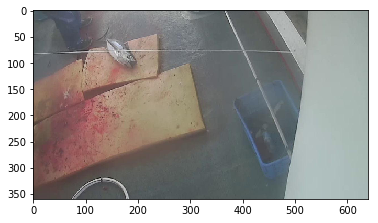

In [202]:
plt.imshow(to_plot(val[0]))

In [203]:
cm = get_cm(inp, 0)

The heatmap shows that (at very low resolution) the model is finding the fish!

(360, 640)


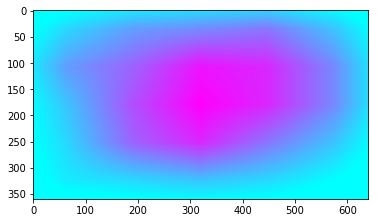

In [204]:
print(cm.shape)
plt.imshow(cm, cmap="cool")

### All convolutional net heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers, and repeat the previous steps.

In [205]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Conv2D(nf, (3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(nf, (3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(nf, (3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(8, (3,3), padding='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [206]:
lrg_model = Sequential(get_lrg_layers())

In [207]:
lrg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_29 (Batc (None, 512, 22, 40)       2048      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 22, 40)       589952    
_________________________________________________________________
batch_normalization_30 (Batc (None, 128, 22, 40)       512       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 128, 22, 40)       147584    
_________________________________________________________________
batch_normalization_31 (Batc (None, 128, 22, 40)       512       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 128, 22, 40)       147584    
_________________________________________________________________
batch_normalization_32 (Batc (None, 128, 22, 40)       512       
__________

In [208]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [209]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, epochs=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3404 samples, validate on 373 samples
Epoch 1/2
3404/3404 [==============================] - 6s 2ms/step - loss: 0.9074 - acc: 0.7350 - val_loss: 2.0053 - val_acc: 0.6247
Epoch 2/2
3404/3404 [==============================] - 4s 1ms/step - loss: 0.2604 - acc: 0.9301 - val_loss: 0.7178 - val_acc: 0.8257


In [210]:
lrg_model.optimizer.lr=1e-5

In [211]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, epochs=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3404 samples, validate on 373 samples
Epoch 1/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.1127 - acc: 0.9709 - val_loss: 0.2480 - val_acc: 0.9464
Epoch 2/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0707 - acc: 0.9821 - val_loss: 0.2063 - val_acc: 0.9464
Epoch 3/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0743 - acc: 0.9786 - val_loss: 0.1683 - val_acc: 0.9571
Epoch 4/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0363 - acc: 0.9894 - val_loss: 0.1801 - val_acc: 0.9544
Epoch 5/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0121 - acc: 0.9976 - val_loss: 0.1479 - val_acc: 0.9625
Epoch 6/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0099 - acc: 0.9976 - val_loss: 0.1464 - val_acc: 0.9759


In [212]:
lrg_model.save_weights(path+'models/lrg_0mp.h5')

In [213]:
lrg_model.load_weights(path+'models/lrg_0mp.h5')

#### Create heatmap

In [214]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], [l[-3].output])

In [215]:
def get_cm2(inp, label):
    conv = conv_fn([inp,0])[0][0][label]
    return skimage.transform.resize(conv.astype(np.int16), (360,640), mode='constant')

In [216]:
inp = np.expand_dims(conv_val_feat[0], 0)

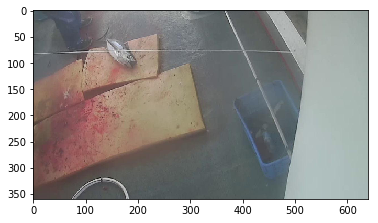

In [217]:
plt.imshow(to_plot(val[0]))

In [218]:
cm = get_cm2(inp, 0)

In [219]:
cm = get_cm2(inp, 4)

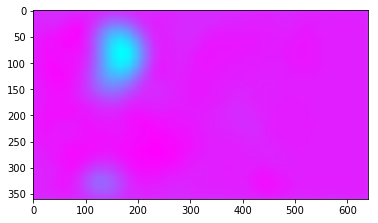

In [220]:
plt.imshow(cm, cmap="cool")

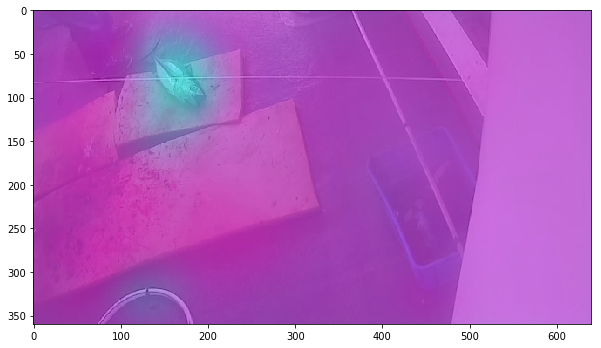

In [221]:
plt.figure(figsize=(10,10))
plot(val[0])
plt.imshow(cm, cmap="cool", alpha=0.5)

### Inception mini-net

Here's an example of how to create and use "inception blocks" - as you see, they use multiple different convolution filter sizes and concatenate the results together. We'll talk more about these next year.

In [231]:
def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1, 1)):
    x = Conv2D(nb_filter, (nb_row, nb_col),
                      strides=subsample, activation='relu', padding='same')(x)
    return BatchNormalization(axis=1)(x)

In [237]:
def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))

    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))

    branch_pool = AveragePooling2D(
        (3, 3), strides=(2, 2), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],
              axis=1)

In [239]:
inp = Input(vgg640.layers[-1].output_shape[1:]) 
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Conv2D(8, (3,3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

/home/cberner/virtual_envs/fastai/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `AveragePooling2D` call to the Keras 2 API: `AveragePooling2D((3, 3), strides=(2, 2), padding="same")`
  # This is added back by InteractiveShellApp.init_path()


In [240]:
lrg_model = Model([inp], outp)

In [241]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [242]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, epochs=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3404 samples, validate on 373 samples
Epoch 1/2
3404/3404 [==============================] - 12s 3ms/step - loss: 1.3831 - acc: 0.5335 - val_loss: 1.5362 - val_acc: 0.5496
Epoch 2/2
3404/3404 [==============================] - 4s 1ms/step - loss: 0.5097 - acc: 0.8563 - val_loss: 0.9506 - val_acc: 0.7507


In [243]:
lrg_model.optimizer.lr=1e-5

In [244]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, epochs=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3404 samples, validate on 373 samples
Epoch 1/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.1874 - acc: 0.9512 - val_loss: 0.5068 - val_acc: 0.8499
Epoch 2/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0761 - acc: 0.9850 - val_loss: 0.2287 - val_acc: 0.9330
Epoch 3/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0347 - acc: 0.9929 - val_loss: 0.1894 - val_acc: 0.9598
Epoch 4/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0208 - acc: 0.9971 - val_loss: 0.1685 - val_acc: 0.9491
Epoch 5/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0120 - acc: 0.9979 - val_loss: 0.1587 - val_acc: 0.9598
Epoch 6/6
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0090 - acc: 0.9994 - val_loss: 0.1886 - val_acc: 0.9625


In [245]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, epochs=10, 
             validation_data=(conv_val_feat, val_labels))

Train on 3404 samples, validate on 373 samples
Epoch 1/10
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0054 - acc: 0.9997 - val_loss: 0.1659 - val_acc: 0.9571
Epoch 2/10
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0043 - acc: 0.9997 - val_loss: 0.1947 - val_acc: 0.9571
Epoch 3/10
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0320 - acc: 0.9921 - val_loss: 0.2378 - val_acc: 0.9491
Epoch 4/10
3404/3404 [==============================] - 5s 1ms/step - loss: 0.0235 - acc: 0.9953 - val_loss: 0.2852 - val_acc: 0.9383
Epoch 5/10
3404/3404 [==============================] - 5s 1ms/step - loss: 0.0441 - acc: 0.9882 - val_loss: 0.2509 - val_acc: 0.9437
Epoch 6/10
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0502 - acc: 0.9882 - val_loss: 0.3818 - val_acc: 0.9249
Epoch 7/10
3404/3404 [==============================] - 4s 1ms/step - loss: 0.0525 - acc: 0.9862 - val_loss: 0.2630 - val_acc: 0.9491
Epoch 8/10
3404

In [246]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [247]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

## Pseudo-labeling

In [256]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')
conv_test_feat = load_array(path+'results/conv_test_feat.dat')

In [257]:
model = vgg_ft_bn(8)

from keras.layers.merge import concatenate
conv_layers,fc_layers = split_at(model, Conv2D)
inp = Input(conv_layers[-1].output_shape[1:])
sz_inp = Input((len(id2size),))
bn_inp = BatchNormalization()(sz_inp)

x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = concatenate([x,bn_inp])
x = Dense(8, activation='softmax')(x)

model = Model([inp, sz_inp], x)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [258]:
model.fit([conv_feat, trn_sizes], trn_labels, batch_size=batch_size, epochs=3, 
             validation_data=([conv_val_feat, val_sizes], val_labels))

Train on 3404 samples, validate on 373 samples
Epoch 1/3
3404/3404 [==============================] - 3s 883us/step - loss: 0.7431 - acc: 0.8261 - val_loss: 0.4012 - val_acc: 0.9223
Epoch 2/3
3404/3404 [==============================] - 1s 315us/step - loss: 0.0648 - acc: 0.9847 - val_loss: 0.1494 - val_acc: 0.9598
Epoch 3/3
3404/3404 [==============================] - 1s 318us/step - loss: 0.0245 - acc: 0.9924 - val_loss: 0.0955 - val_acc: 0.9759


In [259]:
preds = model.predict([conv_test_feat, test_sizes], batch_size=batch_size*2)

In [271]:
gen = image.ImageDataGenerator()

In [272]:
test_batches = gen.flow(conv_test_feat, preds, batch_size=16)

/home/cberner/virtual_envs/fastai/lib/python3.5/site-packages/keras/preprocessing/image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3 or 4 channels on axis 1. However, it was passed an array with shape (1000, 512, 14, 14) (512 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [273]:
val_batches = gen.flow(conv_val_feat, val_labels, batch_size=4)

/home/cberner/virtual_envs/fastai/lib/python3.5/site-packages/keras/preprocessing/image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3 or 4 channels on axis 1. However, it was passed an array with shape (373, 512, 14, 14) (512 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [274]:
batches = gen.flow(conv_feat, trn_labels, batch_size=44)

/home/cberner/virtual_envs/fastai/lib/python3.5/site-packages/keras/preprocessing/image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3 or 4 channels on axis 1. However, it was passed an array with shape (3404, 512, 14, 14) (512 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [282]:
mi = MixIterator([batches, test_batches, val_batches])
batch_n = batches.n + test_batches.n + val_batches.n
batch_size = batches.batch_size + test_batches.batch_size + val_batches.batch_size
print(batches)

In [283]:
bn_model.fit_generator(mi, steps_per_epoch=batch_n/batch_size, epochs=8, validation_data=(conv_val_feat, val_labels))

Epoch 1/8
75/74 [==============================] - 1s 19ms/step - loss: 0.2669 - acc: 0.9498 - val_loss: 0.0344 - val_acc: 0.9920
Epoch 2/8
75/74 [==============================] - 1s 20ms/step - loss: 0.2223 - acc: 0.9578 - val_loss: 0.0202 - val_acc: 0.9946
Epoch 3/8
75/74 [==============================] - 1s 18ms/step - loss: 0.1981 - acc: 0.9639 - val_loss: 0.0077 - val_acc: 0.9973
Epoch 4/8
75/74 [==============================] - 1s 19ms/step - loss: 0.1615 - acc: 0.9723 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 5/8
75/74 [==============================] - 1s 18ms/step - loss: 0.1505 - acc: 0.9771 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 6/8
75/74 [==============================] - 1s 18ms/step - loss: 0.1453 - acc: 0.9778 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 7/8
75/74 [==============================] - 1s 18ms/step - loss: 0.1452 - acc: 0.9767 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 8/8
75/74 [==============================] - 1s 19ms/step - loss: 0.1311 - acc: 0.98

## Submit

In [821]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)

In [829]:
lrg_model.evaluate(conv_val_feat, val_labels, batch_size*2)

500/500 [==============================] - 0s     


[0.11417267167568207, 0.97199999332427978]

In [851]:
preds = model.predict(conv_test_feat, batch_size=batch_size)

In [852]:
preds = preds[1]

In [25]:
test = load_array(path+'results/test_640.dat')

In [5]:
test = load_array(path+'results/test.dat')

In [26]:
preds = conv_model.predict(test, batch_size=32)

In [853]:
subm = do_clip(preds,0.82)

In [854]:
subm_name = path+'results/subm_bb.gz'

In [855]:
# classes = sorted(batches.class_indices, key=batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [856]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.025714,0.025714,0.025714,0.025714,0.820000,0.025714,0.025714,0.025714
1,img_00007.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
2,img_00009.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
3,img_00018.jpg,0.457916,0.025714,0.025714,0.025714,0.025714,0.539635,0.025714,0.025714
4,img_00027.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.102664


In [857]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [858]:
FileLink(subm_name)

/data/jhoward/fast-image/nbs/data/fish/results/subm_bb.gz